Loading model from: A:\Speech Journal\v3 dinov3\best_finetuned_model.pth


Extracting Features: 100%|██████████| 5/5 [00:01<00:00,  2.92it/s]
c:\Users\sreeh\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\manifold\_t_sne.py:1164: FutureWarning: 'n_iter' was renamed to 'max_iter' in version 1.5 and will be removed in 1.7.
  warnings.warn(


Extracted 74 feature vectors of dimension 768
Running t-SNE... (this may take a moment)
Plotting results...


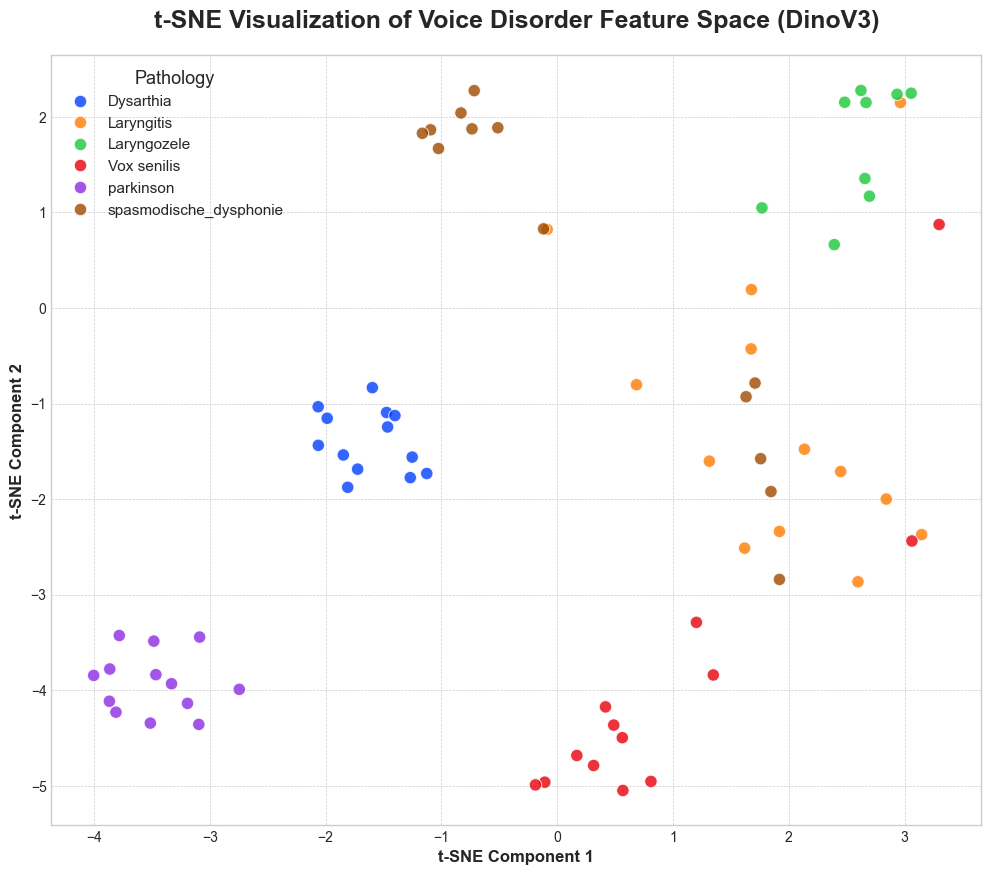

🖼️  High-resolution t-SNE plot saved as 'tsne_feature_space.png'


In [1]:
import torch
import torch.nn as nn
from torch.utils.data import DataLoader, Dataset
from torchvision import datasets, transforms
from transformers import AutoModel, AutoImageProcessor
import numpy as np
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm import tqdm
import os
from PIL import Image

# --- CONFIGURATION ---
# TODO: Update this path to your trained DinoV3 model file
model_path = r'A:\Speech Journal\v3 dinov3\best_finetuned_model.pth'
base_dir = r'A:\Speech Journal\melspectrograms_dataset'
model_name = 'facebook/dinov3-convnext-tiny-pretrain-lvd1689m'
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# =============================================================================
# 1. DATASET AND MODEL DEFINITIONS
# =============================================================================

# Dataset class (from your notebook)
class MelSpectrogramDataset(Dataset):
    def __init__(self, base_dir, split='test', transform=None):
        self.data_dir = os.path.join(base_dir, split)
        self.transform = transform
        self.classes = sorted([d for d in os.listdir(self.data_dir) if os.path.isdir(os.path.join(self.data_dir, d))])
        self.class_to_idx = {cls_name: i for i, cls_name in enumerate(self.classes)}
        self.image_paths = []
        self.labels = []
        for class_name in self.classes:
            class_dir = os.path.join(self.data_dir, class_name)
            for img_file in os.listdir(class_dir):
                self.image_paths.append(os.path.join(class_dir, img_file))
                self.labels.append(self.class_to_idx[class_name])

    def __len__(self):
        return len(self.image_paths)

    def __getitem__(self, idx):
        image = Image.open(self.image_paths[idx]).convert('RGB')
        label = self.labels[idx]
        if self.transform:
            image = self.transform(image)
        return image, label

# Model definition with a method to extract features
class TransformersFeatureExtractor(nn.Module):
    def __init__(self, model_name, num_classes):
        super().__init__()
        self.backbone = AutoModel.from_pretrained(model_name)
        feature_dim = self.backbone.config.hidden_sizes[-1]
        # We don't need the classifier head for this task, just the backbone

    def forward_features(self, x):
        """Extracts the feature embeddings."""
        outputs = self.backbone(pixel_values=x)
        # Global average pooling on the output features
        pooled_features = torch.mean(outputs.last_hidden_state, dim=1)
        return pooled_features
        
    def forward(self, x):
        return self.forward_features(x)

# =============================================================================
# 2. FEATURE EXTRACTION
# =============================================================================

def extract_embeddings(model, dataloader, device):
    """Passes all data through the model to get feature embeddings."""
    model.eval()
    all_features = []
    all_labels = []
    
    with torch.no_grad():
        for images, labels in tqdm(dataloader, desc="Extracting Features"):
            images = images.to(device)
            features = model(images)
            all_features.append(features.cpu().numpy())
            all_labels.extend(labels.numpy())
            
    return np.vstack(all_features), np.array(all_labels)

# =============================================================================
# 3. MAIN EXECUTION SCRIPT
# =============================================================================

if __name__ == "__main__":
    # --- Load Data ---
    processor = AutoImageProcessor.from_pretrained(model_name)
    test_transform = transforms.Compose([
        transforms.Resize((224, 224)),
        transforms.ToTensor(),
        transforms.Normalize(mean=processor.image_mean, std=processor.image_std),
    ])
    
    # Use the test dataset for the visualization
    test_dataset = MelSpectrogramDataset(base_dir, 'test', test_transform)
    test_loader = DataLoader(test_dataset, batch_size=16, shuffle=False)
    class_names = test_dataset.classes
    
    # --- Load Model ---
    print(f"Loading model from: {model_path}")
    model = TransformersFeatureExtractor(model_name, num_classes=len(class_names)).to(device)
    
    # Load the weights from your trained model
    checkpoint = torch.load(model_path, map_location=device)
    # Handle both checkpoint dictionaries and direct state_dicts
    state_dict = checkpoint.get('model_state_dict', checkpoint)
    model.load_state_dict(state_dict, strict=False) # strict=False ignores the missing classifier head

    # --- Extract, Reduce, and Plot ---
    features, labels = extract_embeddings(model, test_loader, device)
    
    print(f"Extracted {features.shape[0]} feature vectors of dimension {features.shape[1]}")
    print("Running t-SNE... (this may take a moment)")
    
    # Run t-SNE to reduce to 2 dimensions
    tsne = TSNE(n_components=2, perplexity=30, random_state=42, n_iter=1000)
    tsne_results = tsne.fit_transform(features)
    
    print("Plotting results...")
    
    # --- Create the Plot ---
    plt.style.use('seaborn-v0_8-whitegrid')
    plt.figure(figsize=(12, 10))
    
    scatter = sns.scatterplot(
        x=tsne_results[:,0],
        y=tsne_results[:,1],
        hue=[class_names[l] for l in labels],
        palette=sns.color_palette("bright", n_colors=len(class_names)),
        s=80,          # Marker size
        alpha=0.8,       # Marker transparency
        edgecolor='w'    # Marker edge color
    )

    plt.title('t-SNE Visualization of Voice Disorder Feature Space (DinoV3)', fontsize=18, fontweight='bold', pad=20)
    plt.xlabel('t-SNE Component 1', fontsize=12, fontweight='bold')
    plt.ylabel('t-SNE Component 2', fontsize=12, fontweight='bold')
    plt.legend(title='Pathology', title_fontsize='13', fontsize='11')
    plt.grid(True, which='both', linestyle='--', linewidth=0.5)
    
    # Save the figure in high resolution
    save_path = 'tsne_feature_space.png'
    plt.savefig(save_path, dpi=300, bbox_inches='tight')
    
    plt.show()
    
    print(f"🖼️  High-resolution t-SNE plot saved as '{save_path}'")

Loading model from: A:\Speech Journal\v6 maxVit\best_full_model.pth


Extracting Features: 100%|██████████| 5/5 [00:01<00:00,  4.74it/s]
c:\Users\sreeh\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\manifold\_t_sne.py:1164: FutureWarning: 'n_iter' was renamed to 'max_iter' in version 1.5 and will be removed in 1.7.
  warnings.warn(


Extracted 74 feature vectors of dimension 512
Running t-SNE... (this may take a moment)
Plotting results...


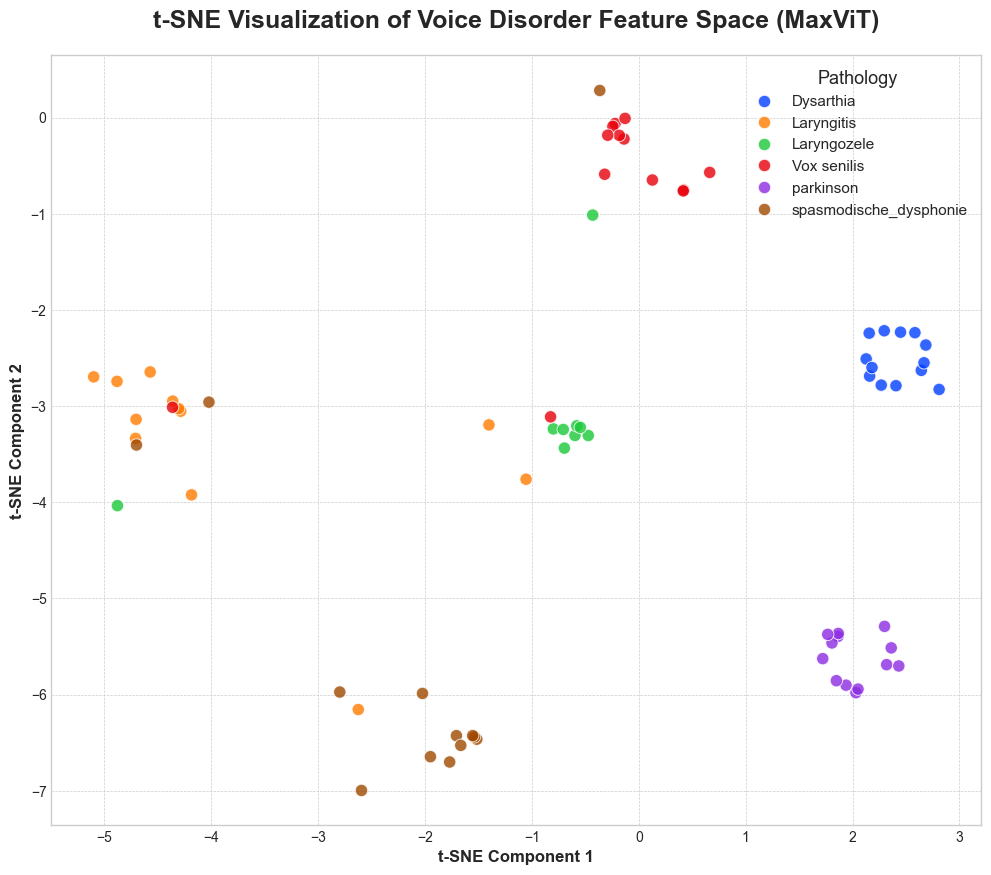

🖼️  High-resolution t-SNE plot for MaxViT saved as 'tsne_feature_space_maxvit.png'


In [5]:
import torch
import torch.nn as nn
from torch.utils.data import DataLoader, Dataset
from torchvision import datasets, transforms
from timm import create_model
import numpy as np
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm import tqdm
import os
from PIL import Image

# --- CONFIGURATION ---
model_path = r'A:\Speech Journal\v6 maxVit\best_full_model.pth'
base_dir = r'A:\Speech Journal\melspectrograms_dataset'
model_name = 'maxvit_tiny_tf_224.in1k'
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# =============================================================================
# 1. DATASET AND MODEL DEFINITIONS
# =============================================================================

# Dataset class (reused from your training scripts)
class MelSpectrogramDataset(Dataset):
    def __init__(self, base_dir, split='test', transform=None):
        self.data_dir = os.path.join(base_dir, split)
        self.transform = transform
        self.classes = sorted([d for d in os.listdir(self.data_dir) if os.path.isdir(os.path.join(self.data_dir, d))])
        self.class_to_idx = {cls_name: i for i, cls_name in enumerate(self.classes)}
        self.image_paths = []
        self.labels = []
        for class_name in self.classes:
            class_dir = os.path.join(self.data_dir, class_name)
            for img_file in os.listdir(class_dir):
                self.image_paths.append(os.path.join(class_dir, img_file))
                self.labels.append(self.class_to_idx[class_name])

    def __len__(self):
        return len(self.image_paths)

    def __getitem__(self, idx):
        image = Image.open(self.image_paths[idx]).convert('RGB')
        label = self.labels[idx]
        if self.transform:
            image = self.transform(image)
        return image, label

# Wrapper class used to train the MaxViT model
class TimmClassifier(nn.Module):
    def __init__(self, model_name, num_classes, drop_rate=0.0):
        super().__init__()
        self.backbone = create_model(model_name, pretrained=False, num_classes=0)
        feature_dim = self.backbone.num_features
        self.classifier = nn.Sequential(
            nn.Linear(feature_dim, 512), nn.BatchNorm1d(512), nn.GELU(),
            nn.Dropout(drop_rate), nn.Linear(512, num_classes)
        )
    def forward(self, x):
        features = self.backbone(x)
        return self.classifier(features)

# Feature extractor model definition
class TimmFeatureExtractor(nn.Module):
    def __init__(self, model_name):
        super().__init__()
        self.backbone = create_model(model_name, pretrained=False, num_classes=0)
        
    def forward(self, x):
        """Extracts the feature embeddings directly from the backbone."""
        return self.backbone(x)

# =============================================================================
# 2. FEATURE EXTRACTION
# =============================================================================

def extract_embeddings(model, dataloader, device):
    """Passes all data through the model to get feature embeddings."""
    model.eval()
    all_features = []
    all_labels = []
    
    with torch.no_grad():
        for images, labels in tqdm(dataloader, desc="Extracting Features"):
            images = images.to(device)
            features = model(images)
            all_features.append(features.cpu().numpy())
            all_labels.extend(labels.numpy())
            
    return np.vstack(all_features), np.array(all_labels)

# =============================================================================
# 3. MAIN EXECUTION SCRIPT
# =============================================================================

if __name__ == "__main__":
    # --- Load Data ---
    test_transform = transforms.Compose([
        transforms.Resize((224, 224)),
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
    ])
    
    test_dataset = MelSpectrogramDataset(base_dir, 'test', test_transform)
    test_loader = DataLoader(test_dataset, batch_size=16, shuffle=False)
    class_names = test_dataset.classes
    
    # --- Load Model ---
    print(f"Loading model from: {model_path}")
    # First, instantiate the full classifier to load the saved weights
    full_model = TimmClassifier(model_name, num_classes=len(class_names))
    checkpoint = torch.load(model_path, map_location=device)
    state_dict = checkpoint.get('model_state_dict', checkpoint)
    full_model.load_state_dict(state_dict)
    
    # Then, create the feature extractor and load just the backbone weights
    feature_extractor = TimmFeatureExtractor(model_name).to(device)
    feature_extractor.backbone.load_state_dict(full_model.backbone.state_dict())

    # --- Extract, Reduce, and Plot ---
    features, labels = extract_embeddings(feature_extractor, test_loader, device)
    
    print(f"Extracted {features.shape[0]} feature vectors of dimension {features.shape[1]}")
    print("Running t-SNE... (this may take a moment)")
    
    tsne = TSNE(n_components=2, perplexity=30, random_state=42, n_iter=1000)
    tsne_results = tsne.fit_transform(features)
    
    print("Plotting results...")
    
    # --- Create the Plot ---
    plt.style.use('seaborn-v0_8-whitegrid')
    plt.figure(figsize=(12, 10))
    
    sns.scatterplot(
        x=tsne_results[:,0],
        y=tsne_results[:,1],
        hue=[class_names[l] for l in labels],
        palette=sns.color_palette("bright", n_colors=len(class_names)),
        s=80, alpha=0.8, edgecolor='w'
    )

    plt.title('t-SNE Visualization of Voice Disorder Feature Space (MaxViT)', fontsize=18, fontweight='bold', pad=20)
    plt.xlabel('t-SNE Component 1', fontsize=12, fontweight='bold')
    plt.ylabel('t-SNE Component 2', fontsize=12, fontweight='bold')
    plt.legend(title='Pathology', title_fontsize='13', fontsize='11')
    plt.grid(True, which='both', linestyle='--', linewidth=0.5)
    
    save_path = 'tsne_feature_space_maxvit.png'
    plt.savefig(save_path, dpi=300, bbox_inches='tight')
    
    plt.show()
    
    print(f"🖼️  High-resolution t-SNE plot for MaxViT saved as '{save_path}'")

Loading model from: A:\Speech Journal\V5 Eva02\best_finetuned_model.pth


Extracting Features: 100%|██████████| 5/5 [00:00<00:00,  8.46it/s]
c:\Users\sreeh\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\manifold\_t_sne.py:1164: FutureWarning: 'n_iter' was renamed to 'max_iter' in version 1.5 and will be removed in 1.7.
  warnings.warn(


Extracted 74 feature vectors of dimension 192
Running t-SNE... (this may take a moment)
Plotting results...


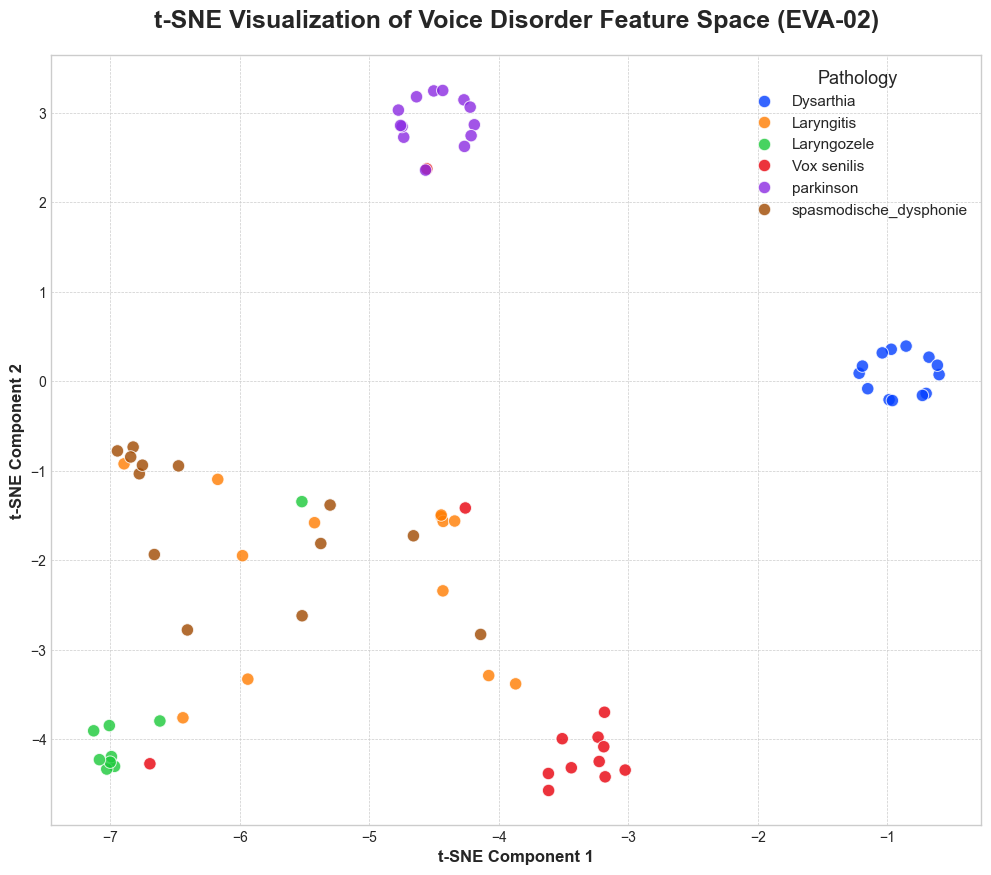

🖼️  High-resolution t-SNE plot for EVA-02 saved as 'tsne_feature_space_eva02.png'


In [6]:
import torch
import torch.nn as nn
from torch.utils.data import DataLoader, Dataset
from torchvision import datasets, transforms
from timm import create_model
import numpy as np
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm import tqdm
import os
from PIL import Image

# --- CONFIGURATION ---
model_path = r'A:\Speech Journal\V5 Eva02\best_finetuned_model.pth'
base_dir = r'A:\Speech Journal\melspectrograms_dataset'
model_name = 'eva02_tiny_patch14_224.mim_in22k'
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# =============================================================================
# 1. DATASET AND MODEL DEFINITIONS
# =============================================================================

# Dataset class (reused from your training scripts)
class MelSpectrogramDataset(Dataset):
    def __init__(self, base_dir, split='test', transform=None):
        self.data_dir = os.path.join(base_dir, split)
        self.transform = transform
        self.classes = sorted([d for d in os.listdir(self.data_dir) if os.path.isdir(os.path.join(self.data_dir, d))])
        self.class_to_idx = {cls_name: i for i, cls_name in enumerate(self.classes)}
        self.image_paths = []
        self.labels = []
        for class_name in self.classes:
            class_dir = os.path.join(self.data_dir, class_name)
            for img_file in os.listdir(class_dir):
                self.image_paths.append(os.path.join(class_dir, img_file))
                self.labels.append(self.class_to_idx[class_name])

    def __len__(self):
        return len(self.image_paths)

    def __getitem__(self, idx):
        image = Image.open(self.image_paths[idx]).convert('RGB')
        label = self.labels[idx]
        if self.transform:
            image = self.transform(image)
        return image, label

# =============================================================================
# 2. FEATURE EXTRACTION
# =============================================================================

def extract_embeddings(model, dataloader, device):
    """Passes all data through the model to get feature embeddings."""
    model.eval()
    all_features = []
    all_labels = []
    
    with torch.no_grad():
        for images, labels in tqdm(dataloader, desc="Extracting Features"):
            images = images.to(device)
            
            # The EVA-02 model's forward_features returns a 3D tensor of patch embeddings
            features_3d = model.forward_features(images)
            
            # We apply global average pooling to get a 2D feature vector per image
            features_2d = torch.mean(features_3d, dim=1)
            
            all_features.append(features_2d.cpu().numpy())
            all_labels.extend(labels.numpy())
            
    return np.vstack(all_features), np.array(all_labels)

# =============================================================================
# 3. MAIN EXECUTION SCRIPT
# =============================================================================

if __name__ == "__main__":
    # --- Load Data ---
    test_transform = transforms.Compose([
        transforms.Resize((224, 224)),
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
    ])
    
    test_dataset = MelSpectrogramDataset(base_dir, 'test', test_transform)
    test_loader = DataLoader(test_dataset, batch_size=16, shuffle=False)
    class_names = test_dataset.classes
    
    # --- Load Model ---
    print(f"Loading model from: {model_path}")
    # Instantiate the model directly using timm, as it was trained without a wrapper
    model = create_model(model_name, pretrained=False, num_classes=len(class_names)).to(device)
    
    checkpoint = torch.load(model_path, map_location=device)
    state_dict = checkpoint.get('model_state_dict', checkpoint)
    model.load_state_dict(state_dict)

    # --- Extract, Reduce, and Plot ---
    features, labels = extract_embeddings(model, test_loader, device)
    
    print(f"Extracted {features.shape[0]} feature vectors of dimension {features.shape[1]}")
    print("Running t-SNE... (this may take a moment)")
    
    # Run t-SNE
    tsne = TSNE(n_components=2, perplexity=30, random_state=42, n_iter=1000)
    tsne_results = tsne.fit_transform(features)
    
    print("Plotting results...")
    
    # --- Create the Plot ---
    plt.style.use('seaborn-v0_8-whitegrid')
    plt.figure(figsize=(12, 10))
    
    sns.scatterplot(
        x=tsne_results[:,0],
        y=tsne_results[:,1],
        hue=[class_names[l] for l in labels],
        palette=sns.color_palette("bright", n_colors=len(class_names)),
        s=80, alpha=0.8, edgecolor='w'
    )

    plt.title('t-SNE Visualization of Voice Disorder Feature Space (EVA-02)', fontsize=18, fontweight='bold', pad=20)
    plt.xlabel('t-SNE Component 1', fontsize=12, fontweight='bold')
    plt.ylabel('t-SNE Component 2', fontsize=12, fontweight='bold')
    plt.legend(title='Pathology', title_fontsize='13', fontsize='11')
    plt.grid(True, which='both', linestyle='--', linewidth=0.5)
    
    save_path = 'tsne_feature_space_eva02.png'
    plt.savefig(save_path, dpi=300, bbox_inches='tight')
    
    plt.show()
    
    print(f"🖼️  High-resolution t-SNE plot for EVA-02 saved as '{save_path}'")